# Using the Modo API

In [61]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [73]:
start_date = "2024-11-05T02:22:22"
end_date = "2024-11-13T08:22:22"
limit = "10000"

url = "https://api.modoenergy.com/pub/v1/gb/elexon/system/fuelhh?publish_date_from=" + start_date + "&publish_date_to=" + end_date + "&limit=" + limit
# this endpoint gives the average generation of each fuel type in the UK for each half hour period in MW
headers = {
    "accept": "application/json",
    "X-Token": "6154030e85b4b167e3e3e89871e6e856ebe1c79963b60c3363b41cc8655c"
}

response = requests.get(url, headers=headers)

# print(response.text)

In [74]:
# convert the response to pandas dataframe

data = json.loads(response.text)

df = pd.DataFrame(data['results'])


# convert startTime to datetime
df['startTime'] = pd.to_datetime(df['startTime'])

print(df.head())


  dataset                publishTime                 startTime settlementDate  \
0  FUELHH  2024-11-13T08:00:00+00:00 2024-11-13 07:30:00+00:00     2024-11-13   
1  FUELHH  2024-11-13T08:00:00+00:00 2024-11-13 07:30:00+00:00     2024-11-13   
2  FUELHH  2024-11-13T08:00:00+00:00 2024-11-13 07:30:00+00:00     2024-11-13   
3  FUELHH  2024-11-13T08:00:00+00:00 2024-11-13 07:30:00+00:00     2024-11-13   
4  FUELHH  2024-11-13T08:00:00+00:00 2024-11-13 07:30:00+00:00     2024-11-13   

   settlementPeriod fuelType  generation  
0                16  INTELEC           0  
1                16   INTNEM        -870  
2                16   INTNED       -1014  
3                16    INTFR         582  
4                16    INTEW        -510  


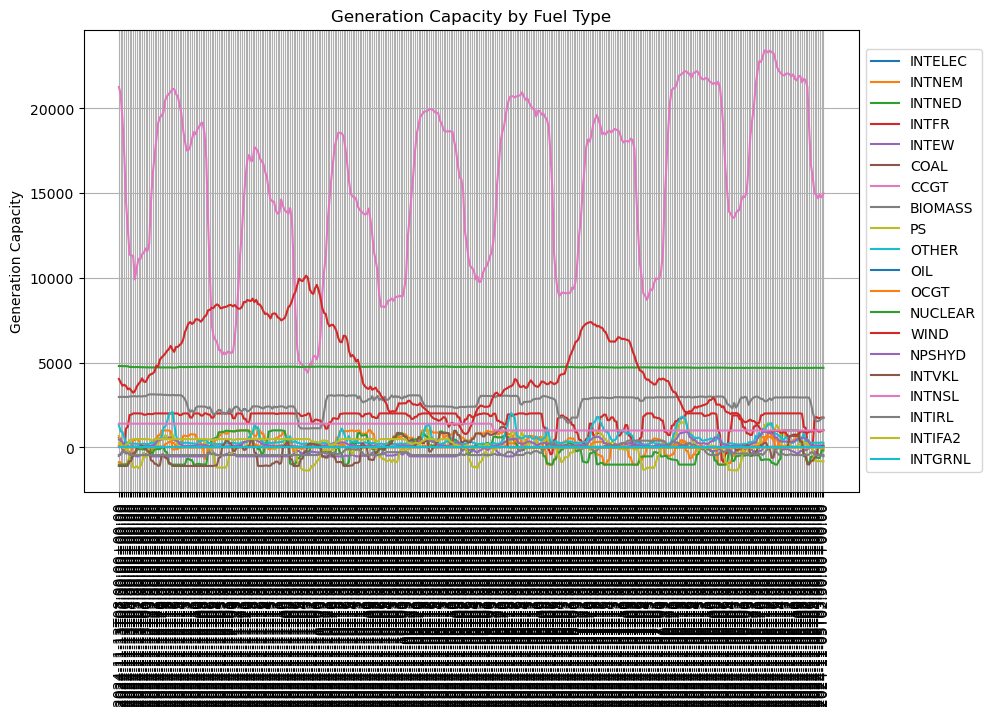

In [75]:
# plot a breakfdown of the fuel types generation capacity over the time period

# for each day
# for each fuel type plot a different color on the graph
# x-axis is the time
# y-axis is the generation capacity

# plot the graph
plt.figure(figsize=(10, 6))
for fuel_type in df['fuelType'].unique():
    fuel_df = df[df['fuelType'] == fuel_type]
    plt.plot(fuel_df['publishTime'], fuel_df['generation'], label=fuel_type)

# only label the x-axis every 100th value
plt.ylabel('Generation Capacity')
plt.title('Generation Capacity by Fuel Type')

# legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# rotate the x-axis labels
plt.xticks(rotation=90)
plt.grid()

plt.show()


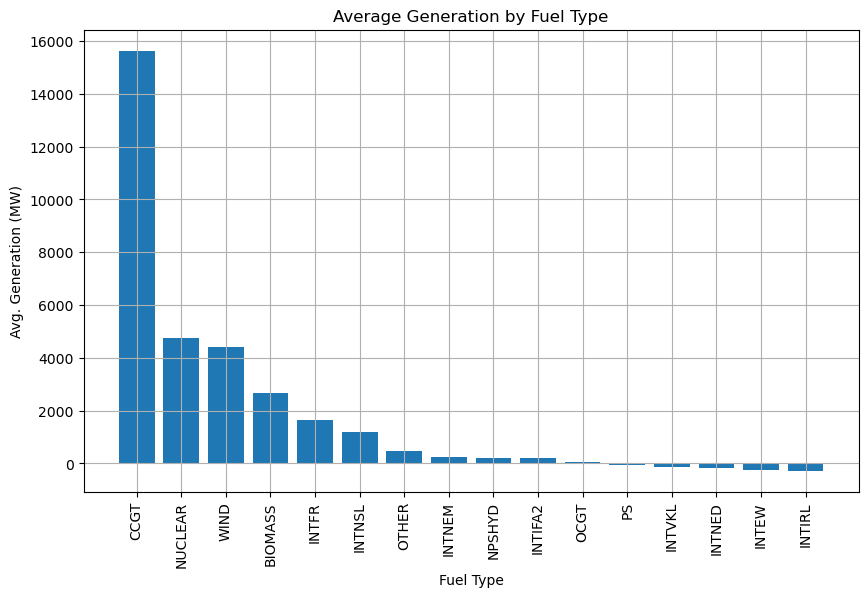

In [76]:
# how much are we generating on average for each fuel type over the time period
average_generation = df.groupby('fuelType')['generation'].mean().sort_values(ascending=False)
average_generation = average_generation[average_generation != 0]

# plot as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(average_generation.index, average_generation)
plt.title('Average Generation by Fuel Type')
plt.ylabel('Avg. Generation (MW)')
plt.xlabel('Fuel Type')
plt.xticks(rotation=90)
# remove columns with average generation of 0
plt.grid()
plt.show()


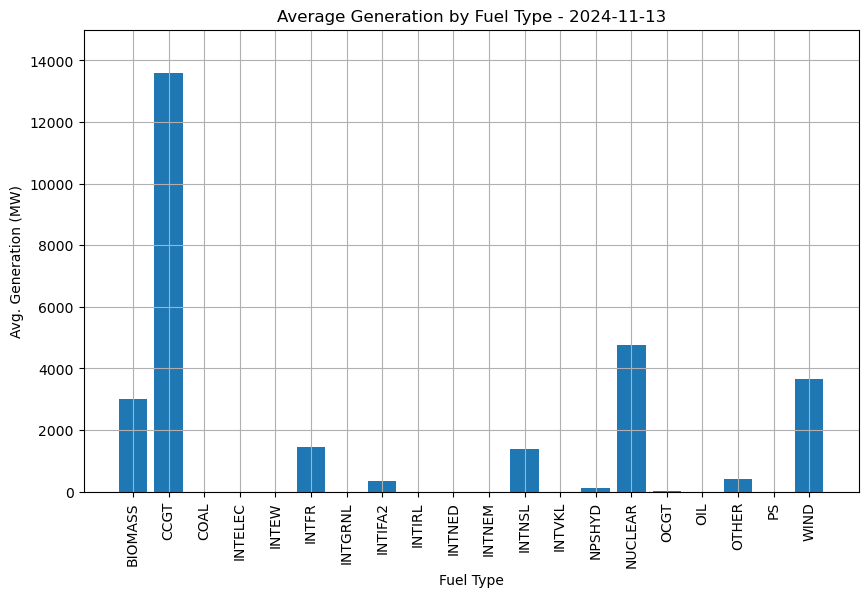

In [79]:

# Prepare figure
fig, ax = plt.subplots(figsize=(10, 6))

days = df['settlementDate'].unique()

def update(day):
    ax.clear()
    daily_data = df[df['settlementDate'] == day]
    average_generation = daily_data.groupby('fuelType')['generation'].mean()
    # average_generation = average_generation[average_generation != 0]  # Exclude 0 generation
    
    ax.bar(average_generation.index, average_generation)
    ax.set_title(f'Average Generation by Fuel Type - {day}')
    ax.set_ylabel('Avg. Generation (MW)')
    # set y limit to the maximum value of the average generation
    ax.set_ylim(0, 15000)
    ax.set_xlabel('Fuel Type')
    ax.set_xticks(range(len(average_generation.index)))
    ax.set_xticklabels(average_generation.index, rotation=90)
    ax.grid()

# Create animation
ani = FuncAnimation(fig, update, frames=days, repeat=False)




In [80]:
# To display the animation in Jupyter Notebook
from IPython.display import HTML
HTML(ani.to_jshtml())